In [10]:
import gymnasium as gym  # Updated from gym to gymnasium [1]
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter  # Updated tensorboard import [1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Defining the DQN Model

In [11]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 128)  # Combined capacity of value/advantage streams
        self.fc3 = nn.Linear(128, 2)   # Direct action-value outputs

    def forward(self, state):
        y = F.relu(self.fc1(state))
        y = F.relu(self.fc2(y))
        return self.fc3(y)

    def select_action(self, state):
        with torch.no_grad():
            q_values = self(state)  # Direct call instead of forward() [1]
            return torch.argmax(q_values).item()

class Memory(deque):  # Simplified memory implementation [1]
    def __init__(self, capacity):
        super().__init__(maxlen=capacity)
        
    def sample(self, batch_size):
        return random.sample(self, batch_size)


## Making the environment and defining the model

In [12]:
# Updated environment creation [1]
env = gym.make('CartPole-v1', render_mode=None)
n_state = env.observation_space.shape[0]

online_net = QNetwork().to(device)
target_net = QNetwork().to(device)
target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.AdamW(online_net.parameters(), lr=1e-4)  # Modern optimizer [1]


## Training Loop

In [14]:
BATCH_SIZE = 128
UPDATE_INTERVAL = 4
GAMMA = 0.99
EPS_START = 0.1
EPS_END = 0.0001
EPS_DECAY = 20000
learning_steps = 0

memory = Memory(50000)
writer = SummaryWriter('logs/dqn/cartpole_degrade')  # Updated tensorboard writer [1]

In [ ]:
epsilon = EPS_START
episode_reward = 0

for epoch in range(350):
    state, _ = env.reset()  # Updated reset unpacking [1]
    episode_reward = 0
    
    for t in range(200):
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = online_net.select_action(state_tensor)
        
        # Updated step returns unpacking [1]
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        memory.append((state, next_state, action, reward, done))
        
        if len(memory) >= BATCH_SIZE:
            # Experience replay
            transitions = memory.sample(BATCH_SIZE)
            batch = list(zip(*transitions))
            learning_steps += 1
            
            # Update target network
            if learning_steps % UPDATE_INTERVAL == 0:
                target_net.load_state_dict(online_net.state_dict())
            
            states = torch.tensor(batch[0], dtype=torch.float32, device=device)
            next_states = torch.tensor(batch[1], dtype=torch.float32, device=device)
            actions = torch.tensor(batch[2], dtype=torch.long, device=device).unsqueeze(1)
            rewards = torch.tensor(batch[3], dtype=torch.float32, device=device).unsqueeze(1)
            dones = torch.tensor(batch[4], dtype=torch.float32, device=device).unsqueeze(1)
            
            # Double DQN update
            with torch.no_grad():
                next_actions = online_net(next_states).argmax(1, keepdim=True)
                target_q = target_net(next_states).gather(1, next_actions)
                target = rewards + (1 - dones) * GAMMA * target_q
            
            current_q = online_net(states).gather(1, actions)
            loss = F.mse_loss(current_q, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epsilon > EPS_END:
                epsilon -= (EPS_START - EPS_END) / EPS_DECAY
        
        
        if done:
            break
        state = next_state
            
    writer.add_scalar('episode_reward', episode_reward, epoch)
    
    if epoch % 10 == 0:
        torch.save(online_net.state_dict(), 'dqn-policy.pt')  # Updated file extension [1]
        print(f'Epoch {epoch}: Reward {episode_reward:.2f}')


Epoch 0: Reward 10.00
Epoch 10: Reward 11.00
Epoch 20: Reward 9.00
Epoch 30: Reward 9.00
Epoch 40: Reward 10.00
Epoch 50: Reward 11.00
Epoch 60: Reward 10.00
Epoch 70: Reward 9.00
Epoch 80: Reward 11.00
Epoch 90: Reward 9.00
Epoch 100: Reward 11.00
Epoch 110: Reward 11.00
Epoch 120: Reward 15.00
Epoch 130: Reward 20.00
Epoch 140: Reward 22.00
Epoch 150: Reward 15.00
Epoch 160: Reward 24.00
Epoch 170: Reward 61.00
Epoch 180: Reward 52.00
Epoch 190: Reward 62.00
Epoch 200: Reward 58.00
Epoch 210: Reward 138.00
Epoch 220: Reward 153.00
Epoch 230: Reward 168.00
Epoch 240: Reward 200.00
Epoch 250: Reward 200.00
Epoch 260: Reward 200.00
Epoch 270: Reward 200.00
Epoch 280: Reward 200.00
Epoch 290: Reward 200.00
Epoch 300: Reward 200.00
Epoch 310: Reward 200.00
Epoch 320: Reward 192.00
Epoch 330: Reward 200.00
Epoch 340: Reward 171.00


## Plotting functions

Run the corrosponding DDQN model first to generate logs

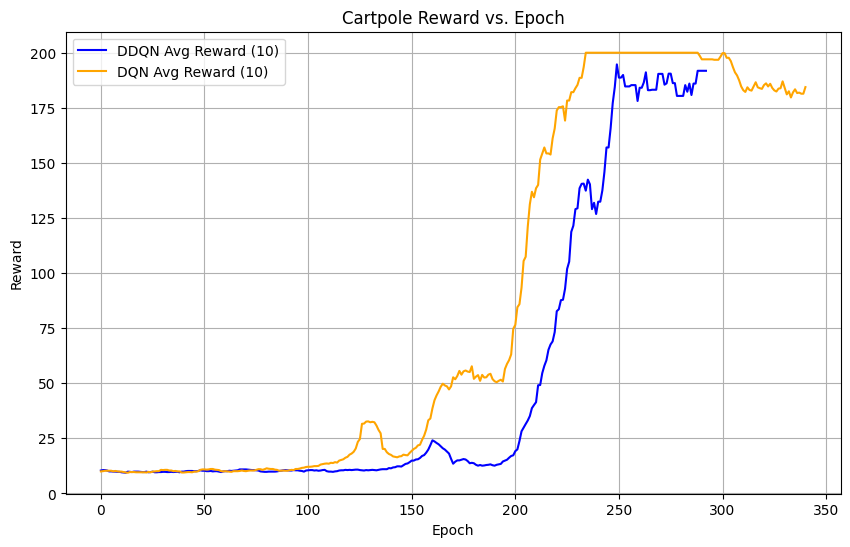

In [17]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib.pyplot as plt

# Load the TensorBoard log data
event_acc = EventAccumulator('logs/ddqn/cartpole')
event_acc.Reload()

# Extract the reward vs. epoch data
reward_events = event_acc.Scalars('episode_reward')
epochs = [event.step for event in reward_events]
rewards_ddqn = [event.value for event in reward_events]

event_acc = EventAccumulator('logs/dqn/cartpole_degrade')
event_acc.Reload()

# Extract the reward vs. epoch data
reward_events = event_acc.Scalars('episode_reward')
epochs = [event.step for event in reward_events]
rewards_dqn = [event.value for event in reward_events]

# apply moving average to smooth both the rewards
rewards_ddqn = np.convolve(rewards_ddqn, np.ones(10)/10, mode='valid')
rewards_dqn = np.convolve(rewards_dqn, np.ones(10)/10, mode='valid')



# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards_ddqn)), rewards_ddqn, label='DDQN Avg Reward (10)', color='blue')
plt.plot(range(len(rewards_dqn)), rewards_dqn, label='DQN Avg Reward (10)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('Cartpole Reward vs. Epoch')
plt.legend()
plt.grid()
plt.show()